Let's assume that we're interested in seeing if a judge has changed his scoring habits after he was caught giving Mexico and Canada significantly lower scores than USA in international diving competitions. We know his previous voting habits, since they led to the investigation and the subsequent requirement for him to retake a certification course and sign documentation that he would not bias his scores.

First, import the necessary libraries.

In [1]:
# To create the data
import numpy as np
import pandas as pd
# To run statistical analyses
import pymc3 as pm
import statsmodels.api as sm
from statsmodels.formula.api import ols
# To plot the data
import matplotlib.pyplot as plt
import scipy.stats as stats

Now let's create our fake data. This particular judge has *not* changed his ways, unfortunately. He thinks he can get away with cheating a little bit longer before he has to change his habits to not get caught again. He reckons that after only four competitions there's not enough data to show that he is still biased.

In [2]:
np.random.seed(1) # For Replicability
USA = np.array([np.random.normal(loc = 80, scale = 1.9, size = 4), np.ones(4)*1])
Canada = np.array([np.random.normal(loc = 78, scale = 1.9, size = 4), np.ones(4)*2])
Mexico = np.array([np.random.normal(loc = 76, scale = 1.9, size = 4), np.ones(4)*3])
data = np.concatenate((USA, Canada, Mexico), axis = 1)
df = pd.DataFrame(data.T, columns = ['Score','Country'])
df.Country = df.Country.astype('category')
df.Country.replace(to_replace = {1:'USA',2:'Canada',3:'Mexico'}, inplace = True)
df

,Score,Country
0,83.086256,USA
1,78.837663,USA
2,78.996474,USA
3,77.961360,USA
4,79.644274,Canada
5,73.627076,Canada
6,81.315142,Canada
7,76.553707,Canada
8,76.606174,Mexico
9,75.526196,Mexico


Run frequentist ANOVA

In [3]:
formula = "Score ~ Country"
model = ols(formula,df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
Country,31.550962,2.0,1.923096,0.201654
Residual,73.828511,9.0,NaN,NaN


In [4]:
model.summary()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     1.923
Date:                Wed, 06 Mar 2019   Prob (F-statistic):              0.202
Time:                        04:15:04   Log-Likelihood:                -27.928
No. Observations:                  12   AIC:                             61.86
Df Residuals:                       9   BIC:                             63.31
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            77.7851      1.432     54.317      0.000      74.546      81.025
Country[T.Mexico]    -2.0360      2.025     -1.005      0.341      -6.617       2.545
Country[T.USA]        1.9354      2.025      0.956      0.364      -2.646       6.517
==============================================================================
Omnibus:                        0.721   Durbin-Watson:                   2.859
Prob(Omnibus):                  0.697   Jarque-Bera (JB):                0.593
Skew:                          -0.068   Prob(JB):                        0.744
Kurtosis:                       1.920   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Run Bayesian ANOVA

In [5]:
# One Hot Encode Data
dummies = pd.get_dummies(df.Country)
#dummies.columns = ['USA','Canada','Mexico']
df = df.join(dummies)

In [6]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10)
    usa = pm.Normal('USA', mu = 80, sd=1.9)
    can = pm.Normal('Canada', mu = 78, sd=1.9)
    mex = pm.Normal('Mexico', mu = 76, sd=1.9)

    # Define likelihood
    likelihood = pm.Normal('Score', 
                           mu = usa*df['USA'] + can*df['Canada'] + mex*df['Mexico'],
                           sd=sigma, 
                           observed=df.Score)

    # Inference!
    trace = pm.sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Mexico, Canada, USA, sigma]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:06<00:00, 1084.56draws/s]
/anaconda3/envs/learn-env/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


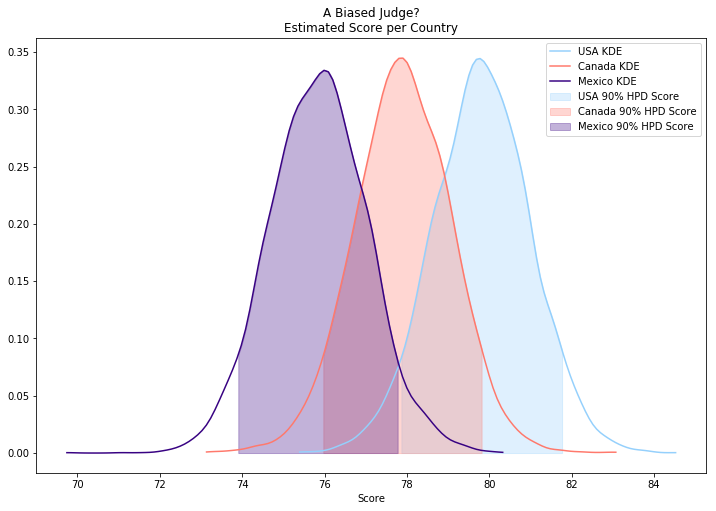

In [7]:
alpha = 0.10
l = len(trace['USA'])
low_bound = int(alpha/2*l)
high_bound = int((1-(alpha/2))*l)

fig, ax = plt.subplots(figsize = (12,8))
for group, color in zip(['USA','Canada','Mexico'],['#95d0fc','#ff796c','#380282']):
    # Estimate KDE
    kde = stats.gaussian_kde(trace[group])
    # plot complete kde curve as line
    pos = np.linspace(trace[group].min(), trace[group].max(), 101)
    plt.plot(pos, kde(pos), color = color, label = '{0} KDE'.format(group))
    # Set shading bounds
    low = np.sort(trace[group])[low_bound]
    high = np.sort(trace[group])[high_bound]
    # plot shaded kde
    shade = np.linspace(low,high,101)
    plt.fill_between(shade,kde(shade), alpha=0.3, color = color, label = "{0} 90% HPD Score".format(group))
plt.legend()
plt.title("A Biased Judge?\nEstimated Score per Country")
plt.xlabel("Score")
plt.show()